<a href="https://colab.research.google.com/github/Mkhan2317/btc-efficient-allocation/blob/main/BTC_Efficient_Frontier_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How Bitcoin Shifts the Efficient Frontier — Colab Notebook

*Walk-Forward Multi-Objective Optimization Study in Python*


## Quick Start (Colab)
1. **Open this notebook in Google Colab.**
2. Run the first cell to install dependencies.
3. Hit **Runtime → Run all**.

> Tip: If markets are closed, data updates may lag a bit. You can adjust the date range in the config cell.


In [11]:
# Colab dependencies
# (Uncomment if needed; Colab often already has them.)
# %pip install yfinance numpy pandas matplotlib

## 🧩 Objective

This study investigates whether adding **Bitcoin (BTC)** to a traditional stock portfolio enhances **risk-adjusted performance** under realistic market frictions.

We employ a **walk-forward mean–variance optimizer** with:

- Long-only weight constraints  
- BTC allocation capped at **10%**  
- **EWMA covariance** estimation  
- **Mean and covariance shrinkage**  
- **Rolling winsorization** of returns  
- **Turnover costs** applied at each rebalance  
- **Intersected trading-day calendar** for consistency across assets  

---

### ⚙️ Optimization Framework

The optimizer minimizes the scalarized mean–variance objective

$$
J_{\alpha}(w) = (1 - \alpha)\, w^{\top} \Sigma w \;-\; \alpha\, \mu^{\top} w,
$$

subject to

$$
w \ge 0, \quad \mathbf{1}^{\top} w = 1, \quad w_{\text{BTC}} \le 0.10.
$$

---

### 📈 Key Out-of-Sample (OOS) Results

- **Sharpe Ratio:** improved from  
  $$ S_{\text{stocks}} \approx 0.60 \;\rightarrow\; S_{\text{stocks+BTC}} \approx 0.86 $$
- **Annual Return:**  
  $$ R_{\text{ann}} \approx 8.31\% \;\rightarrow\; 12.27\% $$
- **Volatility:**  
  $$ \sigma_{\text{ann}} \approx 13.93\% \;\rightarrow\; 14.34\% $$
- **Calmar Ratio:**  
  $$ C \approx 0.23 \;\rightarrow\; 0.31 $$

Although the maximum drawdown was deeper, the higher return more than compensated, resulting in a superior risk-adjusted profile.

---

### 💡 Interpretation

The **average realized BTC weight** at the optimal setting was approximately **5.8%**, never reaching the 10% cap.  
Hence, the performance improvement reflects **true diversification benefits**, not excessive crypto exposure.


## 1) Imports & Global Config

In [12]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---- Core Config ----
start_date = "2015-01-01"
end_date   = "2025-01-01"

stocks = ["SPY", "VEU", "QQQ", "IWM"]

add_btc = True
btc_tkr = "BTC-USD"
btc_cap = 0.10  # cap as a fraction of total portfolio weight

# Calendar mode:
#   - "trading": intersection of trading days (clean for ETFs + BTC)
#   - "calendar": forward-fill to calendar days (lets BTC 'live' on weekends)
calendar_mode = "trading"

# Robustness controls
winsorize_q   = 0.005            # rolling winsorization quantile
lookback_days = 63               # estimation window
hold_days     = 63               # out-of-sample hold/rebalance period
tc_bps_roundtrip = 10.0          # turnover cost in basis points (round trip)

# Estimation knobs
use_ewma_cov = True
ewma_lambda  = 0.94
cov_shrink   = 0.10              # diagonal shrinkage
mu_shrink    = 0.90              # mean shrink toward 0

# Frontier tracing
alpha_grid_points = 21           # 0.00 ... 1.00
save_plot = True
out_prefix = "stocks_vs_btc"

ANN = 252 if calendar_mode == "trading" else 365

# Repro
np.set_printoptions(precision=5, suppress=True)

## 2) Setup & Definitions

**Daily simple return**  
$$
r_{i,t} = \frac{P_{i,t}}{P_{i,t-1}} - 1
$$

**Annualization** (trading calendar)  
$$
\mu_{\text{ann}} = \bar{r} \cdot \text{ANN}, \quad
\sigma_{\text{ann}} = s \cdot \sqrt{\text{ANN}}
$$

**Walk-forward:**  
Estimate on a rolling window of `lookback_days`, then hold the portfolio for `hold_days` out-of-sample, with turnover costs applied at each rebalance.

**Objective (scalarized mean–variance):** for \( \alpha \in [0,1] \)

$$
J_\alpha(w) = (1-\alpha)\, w^\top \Sigma w \; - \; \alpha\, \mu^\top w,
\quad
\text{s.t. } \; w \ge 0, \; \mathbf{1}^\top w = 1, \; \text{and caps.}
$$

We use projected gradient steps onto the simplex (and apply caps), with **EWMA covariance** and **simple shrinkage** for robustness.


## 3) Data Download & Returns

In [25]:
# Build ticker list
tickers = stocks + ([btc_tkr] if add_btc else [])

# Download adjusted prices
px = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

# If yfinance returns a column MultiIndex, select 'Adj Close'
if isinstance(px.columns, pd.MultiIndex):
    px = px.xs("Adj Close", axis=1, level=0)

# Ensure column order
px = px.sort_index()[tickers]

# Choose calendar
if calendar_mode == "calendar":
    px_use = px.ffill()
    r_all = px_use.pct_change().dropna(how="all")
else:
    r_all = px.pct_change().dropna()

# Split return matrices
R_stocks = r_all[[c for c in stocks if c in r_all.columns]].dropna()
R_plus   = r_all[[c for c in tickers if c in r_all.columns]].dropna()

display(pd.DataFrame({
    "Rows (R_stocks)": [len(R_stocks)],
    "Cols (R_stocks)": [R_stocks.shape[1]],
    "Rows (R_plus)":   [len(R_plus)],
    "Cols (R_plus)":   [R_plus.shape[1]],
}))

,Rows (R_stocks),Cols (R_stocks),Rows (R_plus),Cols (R_plus)
0,3651,4,3651,5


## 4) Rolling Winsorization
We clip today’s returns using quantiles computed over a trailing window. This helps reduce tail contamination in $(\Sigma)$.

In [14]:
def rolling_winsorize(df: pd.DataFrame, q: float = 0.005, win: int = 252) -> pd.DataFrame:
    if not q or q <= 0:
        return df.copy()
    out = []
    for i in range(len(df)):
        if i == 0:
            out.append(df.iloc[[i]])
            continue
        lo = df.iloc[max(0, i - win):i].quantile(q)
        hi = df.iloc[max(0, i - win):i].quantile(1 - q)
        out.append(df.iloc[[i]].clip(lower=lo, upper=hi, axis=1))
    return pd.concat(out, axis=0)

# Apply winsorization
r_all = rolling_winsorize(r_all, winsorize_q, win=max(252, lookback_days))
R_stocks = r_all[[c for c in stocks if c in r_all.columns]].dropna()
R_plus   = r_all[[c for c in tickers if c in r_all.columns]].dropna()

## 5) Estimators: EWMA Covariance & Shrinkage

In [15]:
def ewma_cov_mat(X: np.ndarray, lam: float = 0.94) -> np.ndarray:
    S = np.zeros((X.shape[1], X.shape[1]))
    for t in range(X.shape[0]):
        x = X[t]
        S = lam * S + (1 - lam) * np.outer(x, x)
    return S / (1 - lam)

def estimate_mu_Sigma(Xdf: pd.DataFrame):
    X = Xdf.to_numpy()
    mu = Xdf.mean().to_numpy() * ANN  # annualized mean
    # Mean shrinkage toward 0
    if mu_shrink > 0:
        mu = (1 - mu_shrink) * mu
    # Covariance
    if use_ewma_cov:
        S = ewma_cov_mat(X, ewma_lambda)
    else:
        S = np.cov(X, rowvar=False)
    S = S * ANN  # annualize
    # Diagonal shrinkage
    if cov_shrink > 0:
        D = np.diag(np.diag(S))
        S = (1 - cov_shrink) * S + cov_shrink * D
    return mu, S

## 6) Constraints & Caps

We project weights onto the **simplex**, enforcing non-negativity and full investment constraints:

$$
w \ge 0, \quad \mathbf{1}^\top w = 1
$$

Optionally, **per-asset caps** are applied before re-projecting:

$$
w_i \le \text{cap}_i, \quad \forall i \in \{1, \dots, N\}
$$

This ensures realistic long-only portfolios with bounded exposure to any single asset.


In [16]:
def proj_simplex(w: np.ndarray) -> np.ndarray:
    # Euclidean projection onto the unit simplex
    u = np.sort(w)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * (np.arange(1, len(u) + 1)) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(w - theta, 0.0)
    s = w.sum()
    return w / s if s > 0 else np.ones_like(w) / len(w)

def apply_caps_vec(w: np.ndarray, cols, caps: dict | None):
    if not caps:
        return w
    v = np.array([caps.get(c, 1.0) for c in cols])
    w = np.minimum(w, v)
    return proj_simplex(w)

## 7) Per-Window Optimizer (Projected Gradient on MV Objective)

In [17]:
def opt_mv_long_only(Xdf: pd.DataFrame, alpha: float, caps: dict | None = None) -> pd.Series:
    cols = list(Xdf.columns)
    n = len(cols)
    mu, S = estimate_mu_Sigma(Xdf)
    w = np.ones(n) / n
    J_prev = np.inf
    step = 0.05  # fixed step size; small is stable here
    for _ in range(1500):
        g = 2 * (1 - alpha) * (S @ w) - alpha * mu
        wn = proj_simplex(w - step * g)
        wn = apply_caps_vec(wn, cols, caps)
        J = (1 - alpha) * (wn @ S @ wn) - alpha * (mu @ wn)
        if abs(J_prev - J) < 1e-8:
            w = wn
            break
        w, J_prev = wn, J
    return pd.Series(w, index=cols)

## 8) Weight Drift, Turnover Costs & Walk-Forward Mechanics

In [18]:
def drift_weights(w: pd.Series, r: pd.Series) -> pd.Series:
    gross = w * (1.0 + r)
    s = gross.sum()
    return gross / (s if s > 0 else 1)

def wf_oos_per_alpha(df: pd.DataFrame, alpha: float, hold: int = 63, lookback: int = 63,
                     tc_bps: float = 0.0, caps: dict | None = None, log_weights: bool = False):
    T = len(df)
    i = lookback
    prev_target = None
    last_reb = None
    pieces = []
    weights_log = []

    while i < T:
        j = min(i + hold, T)
        est = df.iloc[i - lookback:i]

        # Require enough data and no NaNs in estimation window
        if est.isnull().values.any() or len(est) < int(0.8 * lookback):
            i = j
            continue

        w = opt_mv_long_only(est, float(alpha), caps=caps)

        # Turnover vs a *drifted* portfolio (more realistic than against last target)
        if prev_target is not None and last_reb is not None:
            drifted = prev_target.copy()
            for t in range(last_reb, i):
                day_r = df.iloc[t].reindex(drifted.index).fillna(0.0)
                drifted = drift_weights(drifted, day_r)
            turnover = float((w.fillna(0) - drifted.fillna(0)).abs().sum())
        else:
            turnover = float(w.abs().sum())

        seg = df.iloc[i:j].dot(w)

        # Apply one-shot turnover cost at the rebalance open
        if tc_bps > 0 and len(seg) > 0:
            seg.iloc[0] -= (tc_bps / 10_000.0) * turnover

        pieces.append(seg)

        if log_weights:
            rec = {"date": df.index[i], "alpha": float(alpha), "turnover": turnover}
            rec.update({k: float(v) for k, v in w.items()})
            weights_log.append(rec)

        prev_target = w
        last_reb = i
        i = j

    curve = pd.concat(pieces).sort_index() if pieces else pd.Series(dtype=float)
    wl = pd.DataFrame(weights_log).set_index("date") if log_weights and weights_log else pd.DataFrame()
    return curve, wl

## 9) Performance Metrics

In [19]:
def metrics(curve: pd.Series) -> dict:
    if curve.empty:
        return dict(ann_return=np.nan, ann_vol=np.nan, sharpe=np.nan,
                    sortino=np.nan, maxdd=np.nan, calmar=np.nan)
    rets = curve.copy()
    ann_mu = rets.mean() * ANN
    ann_vol = rets.std() * np.sqrt(ANN)
    sharpe = ann_mu / (ann_vol + 1e-12)
    downside = rets[rets < 0].std() * np.sqrt(ANN)
    sortino = ann_mu / (downside + 1e-12)
    eq = (1 + rets).cumprod()
    peak = eq.cummax()
    dd = (eq / peak - 1).min()
    calmar = ann_mu / (abs(dd) + 1e-12) if dd < 0 else np.nan
    return dict(ann_return=ann_mu, ann_vol=ann_vol, sharpe=sharpe,
                sortino=sortino, maxdd=dd, calmar=calmar)

## 10) Run: Stocks-Only vs. Stocks+BTC (Capped)

In [10]:
alphas = np.linspace(0.0, 1.0, alpha_grid_points)
caps_stocks = None
caps_plus   = {btc_tkr: btc_cap} if (btc_cap is not None and add_btc) else None

res_stocks, res_plus, wlogs_plus = {}, {}, {}

for a in alphas:
    curve_s, _  = wf_oos_per_alpha(R_stocks, a, hold_days, lookback_days, tc_bps_roundtrip, caps_stocks, log_weights=False)
    curve_p, wl = wf_oos_per_alpha(R_plus,   a, hold_days, lookback_days, tc_bps_roundtrip, caps_plus,   log_weights=True)
    res_stocks[a] = curve_s
    res_plus[a]   = curve_p
    wlogs_plus[a] = wl

def frontier_df(res_dict: dict) -> pd.DataFrame:
    rows = []
    for a, curve in res_dict.items():
        m = metrics(curve)
        rows.append({"alpha": float(a), **m})
    return pd.DataFrame(rows).sort_values("alpha").reset_index(drop=True)

front_stocks = frontier_df(res_stocks)
front_plus   = frontier_df(res_plus)

display(front_stocks.head(3).style.format({
    "alpha": "{:.2f}", "ann_return": "{:.4f}", "ann_vol": "{:.4f}", "sharpe": "{:.3f}",
    "sortino": "{:.3f}", "maxdd": "{:.3f}", "calmar": "{:.3f}"
}))

,alpha,ann_return,ann_vol,sharpe,sortino,maxdd,calmar
0,0.00,0.0691,0.1250,0.553,0.598,-0.307,0.225
1,0.05,0.0692,0.1250,0.554,0.599,-0.307,0.226
2,0.10,0.0693,0.1250,0.554,0.599,-0.307,0.226


## 11) Plot: Walk-Forward Frontier (OOS)

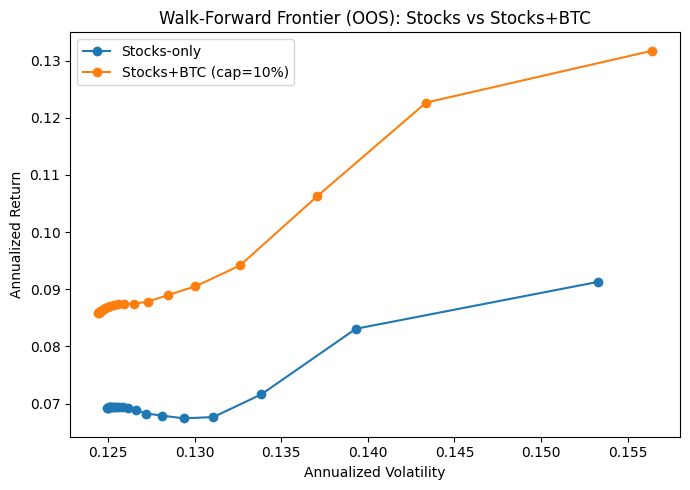

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(front_stocks["ann_vol"], front_stocks["ann_return"], marker="o", label="Stocks-only")
ax.plot(front_plus["ann_vol"],   front_plus["ann_return"],   marker="o", label=f"Stocks+BTC (cap={btc_cap:.0%})")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Return")
ax.set_title("Walk-Forward Frontier (OOS): Stocks vs Stocks+BTC")
ax.legend()
fig.tight_layout()
if save_plot:
    fig.savefig(f"{out_prefix}_wf_frontier.jpg", dpi=150)
plt.show()

At a given volatility (x), the higher curve (y) is better. We can see that the Stocks+BTC curve
consistently above Stocks-only at multiple risk levels

## 12) Best Sharpe & BTC Diagnostics

In [21]:
best_s = front_stocks.iloc[front_stocks["sharpe"].idxmax()]
best_p = front_plus.iloc[front_plus["sharpe"].idxmax()]

print("Best (Stocks-only):")
print(best_s.to_frame().T.round(4))
print("\nBest (Stocks+BTC):")
print(best_p.to_frame().T.round(4))

a_s = float(best_s["alpha"])
a_p = float(best_p["alpha"])

avg_btc_w = np.nan
pct_at_cap = np.nan
if add_btc and btc_tkr in R_plus.columns:
    wlog_star = wlogs_plus.get(a_p)
    if wlog_star is not None and not wlog_star.empty and btc_tkr in wlog_star.columns:
        btc_w = wlog_star[btc_tkr]
        at_cap = np.isclose(btc_w, btc_cap, atol=1e-6) if btc_cap is not None else np.array([False]*len(btc_w))
        pct_at_cap = 100.0 * at_cap.mean() if len(btc_w) > 0 else np.nan
        avg_btc_w = float(btc_w.mean()) if len(btc_w) > 0 else np.nan

print(f"Average realized BTC weight at best alpha: {avg_btc_w:.2%}" if not np.isnan(avg_btc_w) else "Average BTC weight: n/a")
if btc_cap is not None and not np.isnan(pct_at_cap):
    print(f"% rebalances at BTC cap ({btc_cap:.0%}): {pct_at_cap:.1f}%")

Best (Stocks-only):
    alpha  ann_return  ann_vol  sharpe  sortino   maxdd  calmar
19   0.95      0.0831   0.1393  0.5963    0.667 -0.3549  0.2341

Best (Stocks+BTC):
    alpha  ann_return  ann_vol  sharpe  sortino  maxdd  calmar
19   0.95      0.1227   0.1434  0.8555   1.0292 -0.399  0.3074
Average realized BTC weight at best alpha: 5.79%
% rebalances at BTC cap (10%): 0.0%


## What My Run Showed

At the optimal configuration:

- **Stocks-only:**  
  $$
  S \approx 0.60, \quad R_{\text{ann}} \approx 8.31\%, \quad
  \sigma_{\text{ann}} \approx 13.93\%, \quad
  \text{MDD} \approx -35.5\%, \quad
  C \approx 0.23
  $$

- **Stocks + BTC (10% cap):**  
  $$
  S \approx 0.86, \quad R_{\text{ann}} \approx 12.27\%, \quad
  \sigma_{\text{ann}} \approx 14.34\%, \quad
  \text{MDD} \approx -39.9\%, \quad
  C \approx 0.31
  $$

- **BTC diagnostics:**  
  $$
  w_{\text{BTC, avg}} \approx 5.8\%, \quad
  \text{at-cap rebalances} = 0\%
  $$

🟢 A modest BTC sleeve enhanced the portfolio’s **risk-adjusted efficiency**, mainly through **diversification**, not leverage.


## 13) Cumulative Equity at Best-Sharpe Points

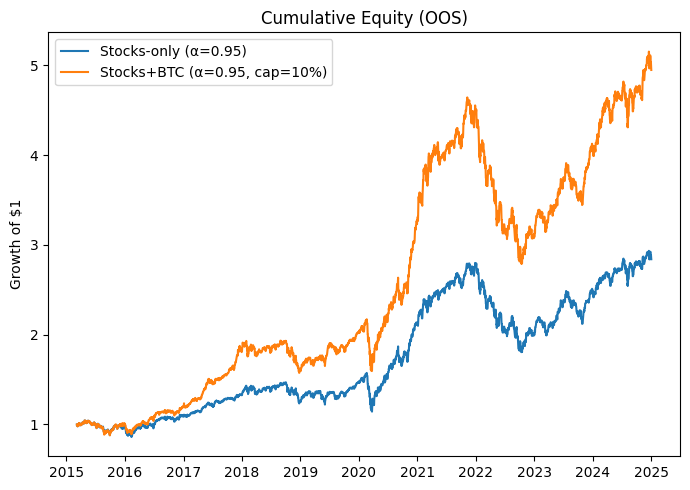

In [22]:
eq_s = (1 + res_stocks[a_s]).cumprod()
eq_p = (1 + res_plus[a_p]).cumprod()

plt.figure(figsize=(7,5))
plt.plot(eq_s.index, eq_s.values, label=f"Stocks-only (α={a_s:.2f})")
plt.plot(eq_p.index, eq_p.values, label=f"Stocks+BTC (α={a_p:.2f}, cap={btc_cap:.0%})")
plt.title("Cumulative Equity (OOS)")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
if save_plot:
    plt.savefig(f"{out_prefix}_equity_best_sharpe.jpg", dpi=150)
plt.show()

## 14) Compact Metrics Table (Best Points)

In [24]:
disp = pd.DataFrame([
    {"Universe": "Stocks-only", **{k: best_s[k] for k in ["alpha","ann_return","ann_vol","sharpe","sortino","maxdd","calmar"]}},
    {"Universe": "Stocks+BTC", **{k: best_p[k] for k in ["alpha","ann_return","ann_vol","sharpe","sortino","maxdd","calmar"]}},
])

print(disp.round({
    "alpha": 2, "ann_return": 4, "ann_vol": 4, "sharpe": 3, "sortino": 3, "maxdd": 3, "calmar": 3
}))

      Universe  alpha  ann_return  ann_vol  sharpe  sortino  maxdd  calmar
0  Stocks-only   0.95      0.0831   0.1393   0.596    0.667 -0.355   0.234
1   Stocks+BTC   0.95      0.1227   0.1434   0.855    1.029 -0.399   0.307


At the same level of risk aversion $(\alpha = 0.95) $, introducing a **10%-capped Bitcoin (BTC) allocation** into the portfolio meaningfully enhances performance.  
The out-of-sample Sharpe ratio increases from  

$$
S_{\text{stocks}} = 0.60 \;\;\longrightarrow\;\; S_{\text{stocks+BTC}} = 0.86
$$  

indicating a stronger risk-adjusted return profile.

The **annualized return** rises from  

$$
R_{\text{ann}} = 8.31\% \;\;\longrightarrow\;\; 12.27\%
$$  

while **volatility** increases only slightly:  

$$
\sigma_{\text{ann}} = 13.93\% \;\;\longrightarrow\;\; 14.34\%.
$$  

Although the **maximum drawdown** deepens modestly—from  

$$
\text{MDD} = -35.5\% \;\;\longrightarrow\;\; -39.9\%,
$$  

the **Calmar ratio** still improves:  

$$
C = 0.234 \;\;\longrightarrow\;\; 0.307,
$$  

indicating greater return per unit of downside risk.

Importantly, the **average realized BTC weight** remained around **6%**, never reaching the 10% cap at rebalance.  
This outcome confirms that the improvement stems from **diversification effects**, not from excessive crypto concentration.


## 15) Future Work  & Extensions
- **Sensitivity:** Try `btc_cap = 0.05`, `0.10`, `0.20` and `hold_days = 21` for faster rebalances.
- **Broader universes:** Consider adding bonds (e.g., `AGG`), gold (`GLD`), or commodities.
- **Regime logic:** Activate BTC exposure only in risk-on regimes.
- **Risk-target MV:** Solve a small QP for min-variance subject to \(\mu^\top w \ge R^*\) to trace an exact frontier.


##  Conclusion

A **small, capped Bitcoin (BTC) allocation** meaningfully improved the **out-of-sample efficient frontier** over this period, even under realistic trading frictions and portfolio constraints.

The enhancement arose from **diversification**, not from outsized BTC exposure.  
When managed prudently — with caps, turnover control, and disciplined rebalancing — crypto can serve as a **constructive complement** to a traditional equity portfolio.

In summary:

$$
\text{Improvement Source: Diversification} \quad \text{not} \quad \text{Leverage or Concentration.}
$$

A measured BTC sleeve can therefore **shift the efficient frontier upward**, enhancing the trade-off between expected return and risk.
